In [231]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [232]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'cpc'

yearRange = [1981, 2018]

In [234]:
# load the sacks crop calendars

sacksMaizeStart = np.genfromtxt('%s/sacks/sacks-planting-end-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeStart[sacksMaizeStart<0] = np.nan
sacksMaizeEnd = np.genfromtxt('%s/sacks/sacks-harvest-start-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeEnd[sacksMaizeEnd<0] = np.nan

sacksMaizeStart = np.roll(sacksMaizeStart, int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeEnd = np.roll(sacksMaizeEnd, int(sacksMaizeEnd.shape[1]/2), axis=1)

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)


In [235]:
# load gdd/kdd from cpc temperature data
with gzip.open('%s/kdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    kdd = pickle.load(f)

with gzip.open('%s/gdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    gdd = pickle.load(f)
    
# kddWeekly = np.full([kdd.shape[0], kdd.shape[1], (yearRange[1]-yearRange[0]+1), 53], np.full)
# gddWeekly = np.full([gdd.shape[0], gdd.shape[1], (yearRange[1]-yearRange[0]+1), 53], np.full)
# for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
#     print('loading weekly data for %d'%year)
#     with gzip.open('%s/kdd-weekly-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#         curKddWeekly = pickle.load(f)

#     with gzip.open('%s/gdd-weekly-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#         curGddWeekly = pickle.load(f)
    
#     kddWeekly[:, :, y, :] = curKddWeekly
#     gddWeekly[:, :, y, :] = curGddWeekly

with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lon = pickle.load(f)


In [237]:
if os.path.isfile('%s/seasonal-precip-maize-gpcp.dat'%(dataDirDiscovery)):
    with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)

In [238]:
if wxData == 'cpc':
    kdd = kdd[:,:,1:]
    gdd = gdd[:,:,1:]

In [239]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data

if os.path.isfile('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1])) and os.path.isfile('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1])):
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
else:
    gddTrends = np.full([gdd.shape[0], gdd.shape[1]], np.nan)
    kddTrends = np.full([kdd.shape[0], kdd.shape[1]], np.nan)

    for x in range(gddTrends.shape[0]):
        for y in range(gddTrends.shape[1]):
            nn = np.where(~np.isnan(gdd[x, y, :]))[0]
            if len(nn) == gdd.shape[2]:
                X = sm.add_constant(range(gdd.shape[2]))
                mdl = sm.OLS(gdd[x, y, :], X).fit()
                gddTrends[x, y] = mdl.params[1]

            nn = np.where(~np.isnan(kdd[x, y, :]))[0]
            if len(nn) == kdd.shape[2]:
                X = sm.add_constant(range(kdd.shape[2]))
                mdl = sm.OLS(kdd[x, y, :], X).fit()
                kddTrends[x, y] = mdl.params[1]

    # if a grid cell has no gdd/kdds, trend will be exactly 0 - set to nan
    kddTrends[kddTrends == 0] = np.nan
    gddTrends[gddTrends == 0] = np.nan
    
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'wb') as f:
        pickle.dump(kddTrends, f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'wb') as f:
        pickle.dump(gddTrends, f)


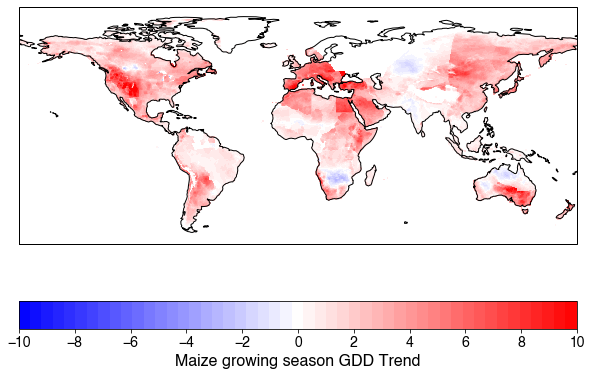

In [240]:
cRange=[-10, 10]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(gddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('%s growing season GDD Trend'%crop)
ax.coastlines()

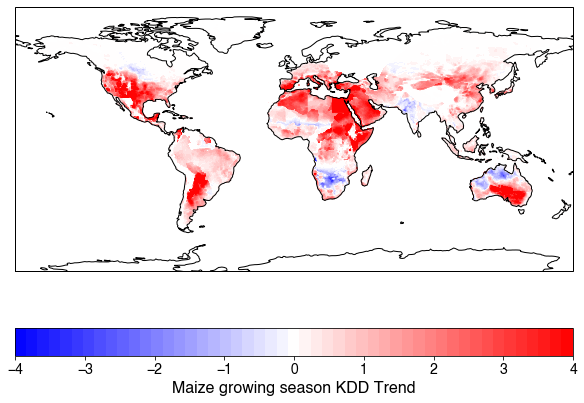

In [241]:
cRange=[-4, 4]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

In [242]:
# kddDetrend = np.full(kdd.shape, np.nan)
# gddDetrend = np.full(gdd.shape, np.nan)

# for xlat in range(kdd.shape[0]):
#     for ylon in range(kdd.shape[1]):
#         nn = np.where((~np.isnan(kdd[xlat, ylon, 0:kdd.shape[2]])) & (~np.isnan(gdd[xlat, ylon, 0:gdd.shape[2]])))[0]
#         if len(nn) == kdd.shape[2]:
#             gddDetrend[xlat, ylon, nn] = scipy.signal.detrend(gdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(gdd[xlat, ylon, nn]))
#             kddDetrend[xlat, ylon, nn] = scipy.signal.detrend(kdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(kdd[xlat, ylon, nn]))
        

In [243]:
# load NASS yield data

nassProd1 = pd.read_csv('%s/nass/nass-maize-production-1961-1974.csv'%dataDirDiscovery)
nassProd2 = pd.read_csv('%s/nass/nass-maize-production-1975-1994.csv'%dataDirDiscovery)
nassProd3 = pd.read_csv('%s/nass/nass-maize-production-1995-2019.csv'%dataDirDiscovery)
nassProd = pd.concat([nassProd1[::-1], nassProd2[::-1], nassProd3[::-1]])

nass1 = pd.read_csv('%s/nass/maize-yield-1961-1978.csv'%dataDirDiscovery)
nass2 = pd.read_csv('%s/nass/maize-yield-1979-1998.csv'%dataDirDiscovery)
nass3 = pd.read_csv('%s/nass/maize-yield-1999-2019.csv'%dataDirDiscovery)

nass = pd.concat([nass1[::-1], nass2[::-1], nass3[::-1]])


In [244]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [245]:
nassStates = list(nass['State'])
nassStateAbvs = []
for s in nassStates:
    nassStateAbvs.append(usStateAbbrev[s.lower().title()])
nass['StateAbvs'] = nassStateAbvs

nassProdStates = list(nassProd['State'])
nassProdStateAbvs = []
for s in nassProdStates:
    nassProdStateAbvs.append(usStateAbbrev[s.lower().title()])
nassProd['StateAbvs'] = nassProdStateAbvs

In [246]:
maizeYieldDeepak = []
for year in range(1981, 2013+1):
    curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    if len(maizeYieldDeepak) == 0:
        maizeYieldDeepak = curMaizeYield
    else:
        maizeYieldDeepak = xr.concat([maizeYieldDeepak, curMaizeYield], dim='time')
    
maizeYieldDeepak.load()

# flip latitude axis so top is +90
latDeepak = np.flipud(maizeYieldDeepak.latitude)
lonDeepak = np.roll(maizeYieldDeepak.longitude, int(len(maizeYieldDeepak.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYieldDeepak['Data'] = maizeYieldDeepak.Data.transpose('latitude', 'longitude', 'time', 'level')
maizeYieldDeepakData = np.roll(np.flip(maizeYieldDeepak.Data, axis=0), int(len(maizeYieldDeepak.longitude)/2), axis=1)

maizeYieldDeepak['latitude'] = latDeepak
maizeYieldDeepak['longitude'] = lonDeepak
maizeYieldDeepak['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(maizeYieldDeepakData))

In [247]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i, val in enumerate(data):
        # start sequence
        if ~np.isnan(val) and ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif (np.isnan(val) and ptCur[0] >= 0):
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptCur = (-1, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
    return ptMax

In [271]:
minCropYears = 20
minCropYearsDeepak = 20

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)):
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))
else:
    usCounties = gpd.read_file('%s/us-county-lat-long/c_02jn20.shp'%dataDirDiscovery)

    usCounties['temp'] = np.full(len(usCounties), np.nan)
    usCounties['tempLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['tempLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['gdd'] = np.full(len(usCounties), np.nan)
    usCounties['kdd'] = np.full(len(usCounties), np.nan)
#     usCounties['gddWeekly'] = np.full(len(usCounties), np.nan)
#     usCounties['kddWeekly'] = np.full(len(usCounties), np.nan)
    usCounties['gddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecip'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYield'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProd'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdYears'] = np.full(len(usCounties), np.nan)

    # this is needed to store list in dataframe... kind of hacky
    usCounties = usCounties.astype(object)

    for c in range(usCounties.shape[0]):
        
        if c % 100 == 0:
            print('%.0f %% done'%(c/usCounties.shape[0]*100))
        
        bounds = usCounties['geometry'][c].bounds
        lat1 = bounds[1]
        lat2 = bounds[3]
        lon1 = bounds[0]
        lon2 = bounds[2]

        if lon1 < 0: lon1 += 360
        if lon2 < 0: lon2 += 360

        deepakLatInds = [np.where(abs(latDeepak-lat2) == np.nanmin(abs(latDeepak-lat2)))[0][0],
                   np.where(abs(latDeepak-lat1) == np.nanmin(abs(latDeepak-lat1)))[0][0]]
        deepakLonInds = [np.where(abs(lonDeepak-lon1) == np.nanmin(abs(lonDeepak-lon1)))[0][0],
                   np.where(abs(lonDeepak-lon2) == np.nanmin(abs(lonDeepak-lon2)))[0][0]]
            
        tempLatInds = [np.where(abs(lat-lat2) == np.nanmin(abs(lat-lat2)))[0][0],
                   np.where(abs(lat-lat1) == np.nanmin(abs(lat-lat1)))[0][0]]
        tempLonInds = [np.where(abs(lon-lon1) == np.nanmin(abs(lon-lon1)))[0][0],
                   np.where(abs(lon-lon2) == np.nanmin(abs(lon-lon2)))[0][0]]
        
        prLatInds = [np.where(abs(sacksLat-lat2) == np.nanmin(abs(sacksLat-lat2)))[0][0],
                   np.where(abs(sacksLat-lat1) == np.nanmin(abs(sacksLat-lat1)))[0][0]]
        prLonInds = [np.where(abs(sacksLon-lon1) == np.nanmin(abs(sacksLon-lon1)))[0][0],
                   np.where(abs(sacksLon-lon2) == np.nanmin(abs(sacksLon-lon2)))[0][0]]
        
        if len(tempLatInds) == 0 or len(tempLonInds) == 0 or \
           len(prLatInds) == 0 or len(prLonInds) == 0:
            break

        usCounties['tempLatInds'][c] = tempLatInds
        usCounties['tempLonInds'][c] = tempLonInds
        
        usCounties['prLatInds'][c] = prLatInds
        usCounties['prLonInds'][c] = prLonInds
        
        deepakLatIndsRange = np.arange(min(deepakLatInds), max(deepakLatInds)+1)
        deepakLonIndsRange = np.arange(min(deepakLonInds), max(deepakLonInds)+1)
        
        if len(deepakLatInds) > 1:
            countyYieldDeepak = np.nanmean(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :], axis=0)
        else:
            countyYieldDeepak = np.squeeze(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :])
        
        if len(deepakLonInds) > 1:
            countyYieldDeepak = np.nanmean(countyYieldDeepak[deepakLonIndsRange, :], axis=0)
        else:
            countyYieldDeepak = np.squeeze(countyYieldDeepak[deepakLonIndsRange, :])
        
        # add padding so yield array is same length as nass arrays
        countyYieldDeepak = np.pad(countyYieldDeepak, (0, 5), 'constant', constant_values=(np.nan))
        
        tempLatIndsRange = np.arange(min(tempLatInds), max(tempLatInds)+1)
        tempLonIndsRange = np.arange(min(tempLonInds), max(tempLonInds)+1)
        
        prLatIndsRange = np.arange(min(prLatInds), max(prLatInds)+1)
        prLonIndsRange = np.arange(min(prLonInds), max(prLonInds)+1)

        if len(tempLatIndsRange) > 1:
            countyGdd = np.nanmean(gdd[tempLatIndsRange, :, :], axis=0)
            countyKdd = np.nanmean(kdd[tempLatIndsRange, :, :], axis=0)
            
#             countyGddWeekly = np.nanmean(gddWeekly[tempLatIndsRange, :, :, :], axis=0)
#             countyKddWeekly = np.nanmean(kddWeekly[tempLatIndsRange, :, :, :], axis=0)
        else:
            countyGdd = np.squeeze(gdd[tempLatIndsRange, :, :])
            countyKdd = np.squeeze(kdd[tempLatIndsRange, :, :])
            
#             countyGddWeekly = np.squeeze(gddWeekly[tempLatIndsRange, :, :, :])
#             countyKddWeekly = np.squeeze(kddWeekly[tempLatIndsRange, :, :, :])
        
        if len(prLatIndsRange) > 1:
            countyPrecip = np.nanmean(seasonalPrecip[prLatIndsRange, :, :], axis=0)
        else:
            countyPrecip = np.squeeze(seasonalPrecip[prLatIndsRange, :, :])

        if len(tempLonIndsRange) > 1:
            countyGdd = np.nanmean(countyGdd[tempLonIndsRange, :], axis=0)
            countyKdd = np.nanmean(countyKdd[tempLonIndsRange, :], axis=0)
            
#             countyGddWeekly = np.nanmean(countyGddWeekly[tempLonIndsRange, :, :], axis=0)
#             countyKddWeekly = np.nanmean(countyKddWeekly[tempLonIndsRange, :, :], axis=0)
        else:
            countyGdd = np.squeeze(countyGdd[tempLonIndsRange, :])
            countyKdd = np.squeeze(countyKdd[tempLonIndsRange, :])
            
#             countyGddWeekly = np.squeeze(countyGddWeekly[tempLonIndsRange, :, :])
#             countyKddWeekly = np.squeeze(countyKddWeekly[tempLonIndsRange, :, :])
        
        if len(prLonIndsRange) > 1:
            countyPrecip = np.nanmean(countyPrecip[prLonIndsRange, :], axis=0)
        else:
            countyPrecip = np.squeeze(countyPrecip[prLonIndsRange, :])

        curCountyName = usCounties['COUNTYNAME'][c].lower()
        nassYieldCounties = np.array(list(map(str.lower, nass['County'])))
        nassProdCounties = np.array(list(map(str.lower, nassProd['County'])))

        curStateName = usCounties['STATE'][c].lower()
        nassYieldStates = np.array(list(map(str.lower, nass['StateAbvs'])))
        nassProdStates = np.array(list(map(str.lower, nassProd['StateAbvs'])))

        countyIndYield = np.where((curCountyName == nassYieldCounties) & (curStateName == nassYieldStates))[0]
        countyIndProd = np.where((curCountyName == nassProdCounties) & (curStateName == nassProdStates))[0]

        curCountyYieldYears = np.array(list(nass['Year']))
        curCountyYieldYears = curCountyYieldYears[countyIndYield]

        curCountyYield = np.array(list(nass['Value']))
        curCountyYield = curCountyYield[countyIndYield]
        
        curCountyProdYears = np.array(list(nassProd['Year']))
        curCountyProdYears = curCountyProdYears[countyIndProd]
        
        curCountyProd = np.array(list(nassProd['Value']))
        curCountyProd = curCountyProd[countyIndProd]

        yieldYearsUniform = np.arange(1981, 2018+1)
        yieldUniform = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrend = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrendNorm = np.full(yieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountyYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(yieldYearsUniform):
                yieldUniform[indUniform] = curCountyYield[y]
        
        prodYearsUniform = np.arange(1981, 2018+1)
        prodUniform = np.full(prodYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyProdYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(prodYearsUniform):
                prodUniform[indUniform] = float(curCountyProd[y].replace(',', ''))
        
        # find longest consequtative sequence of years with yield data
        ptMax = findConsec(yieldUniform)
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMax[0], ptMax[1])
            
            yieldUniformDetrendNorm[indsNass] = scipy.signal.detrend(yieldUniform[indsNass]) / np.linalg.norm(scipy.signal.detrend(yieldUniform[indsNass]))
            yieldUniformDetrend[indsNass] = scipy.signal.detrend(yieldUniform[indsNass])
            yieldUniform[:ptMax[0]] = np.nan
            yieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(yieldUniform[indsNass])))
            mdl = sm.OLS(yieldUniform[indsNass], X).fit()
            usCounties['maizeYieldTrend'][c] = mdl.params[1]
            
            prodUniform[:ptMax[0]] = np.nan
            prodUniform[ptMax[1]:] = np.nan
            
            if len(np.where(np.isnan(prodUniform[ptMax[0]:ptMax[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(prodUniform[ptMax[0]:ptMax[1]+1])))
                mdl = sm.OLS(prodUniform[ptMax[0]:ptMax[1]+1], X).fit()
                usCounties['maizeProdTrend'][c] = mdl.params[1]
        
        usCounties['maizeYieldYears'][c] = yieldYearsUniform
        usCounties['maizeYield'][c] = yieldUniform
        usCounties['maizeYieldDetrend'][c] = yieldUniformDetrend
        usCounties['maizeYieldDetrendNorm'][c] = yieldUniformDetrendNorm
        usCounties['maizeProdYears'][c] = prodYearsUniform
        usCounties['maizeProd'][c] = prodUniform
            
            
        # do the same but with deepak data            
        yieldUniformDetrendDeepak = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrendNormDeepak = np.full(yieldYearsUniform.shape, np.nan)

        ptMaxDeepak = findConsec(countyYieldDeepak)
        
        if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= minCropYearsDeepak:

            indsDeepak = np.arange(ptMaxDeepak[0], ptMaxDeepak[1])

            yieldUniformDetrendNormDeepak[indsDeepak] = scipy.signal.detrend(countyYieldDeepak[indsDeepak]) / np.linalg.norm(scipy.signal.detrend(countyYieldDeepak[indsDeepak]))
            yieldUniformDetrendDeepak[indsDeepak] = scipy.signal.detrend(countyYieldDeepak[indsDeepak])
            countyYieldDeepak[:ptMaxDeepak[0]] = np.nan
            countyYieldDeepak[ptMaxDeepak[1]:] = np.nan

            X = sm.add_constant(range(len(countyYieldDeepak[indsDeepak])))
            mdl = sm.OLS(countyYieldDeepak[indsDeepak], X).fit()
            usCounties['maizeYieldTrendDeepak'][c] = mdl.params[1]
        
        usCounties['maizeYieldDeepak'][c] = countyYieldDeepak
        usCounties['maizeYieldDetrendDeepak'][c] = yieldUniformDetrendDeepak
        usCounties['maizeYieldDetrendNormDeepak'][c] = yieldUniformDetrendNormDeepak
        
        countyGdd[countyGdd < 0] = np.nan
        indsGdd = np.where(~np.isnan(countyGdd))[0]
        usCounties['gdd'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gdd'][c] = countyGdd[indsGdd]
        usCounties['gddDetrend'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrend'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) 
        usCounties['gddDetrendNorm'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrendNorm'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) / np.linalg.norm(scipy.signal.detrend(countyGdd[indsGdd]))
        X = sm.add_constant(range(len(countyGdd[indsGdd])))
        mdl = sm.OLS(countyGdd[indsGdd], X).fit()
        usCounties['gddTrend'][c] = mdl.params[1]

        countyKdd[countyKdd < 0] = np.nan
        indsKdd = np.where(~np.isnan(countyKdd))[0]
        usCounties['kdd'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kdd'][c][indsKdd] = countyKdd[indsKdd]
        usCounties['kddDetrend'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrend'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) 
        usCounties['kddDetrendNorm'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrendNorm'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) / np.linalg.norm(scipy.signal.detrend(countyKdd[indsKdd]))
        X = sm.add_constant(range(len(countyKdd[indsKdd])))
        mdl = sm.OLS(countyKdd[indsKdd], X).fit()
        usCounties['kddTrend'][c] = mdl.params[1]

        countyPrecip[countyPrecip < 0] = np.nan
        indsPr = np.where(~np.isnan(countyPrecip))[0]
        usCounties['seasonalPrecip'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecip'][c][indsPr] = countyPrecip[indsPr]
        usCounties['seasonalPrecipDetrend'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrend'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) 
        usCounties['seasonalPrecipDetrendNorm'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrendNorm'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) / np.linalg.norm(scipy.signal.detrend(countyPrecip[indsPr]))

        X = sm.add_constant(range(len(countyPrecip[indsPr])))
        mdl = sm.OLS(countyPrecip[indsPr], X).fit()
        usCounties['seasonalPrecipTrend'][c] = mdl.params[1]
        
    usCounties.to_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))

0 % done
3 % done
6 % done
9 % done
12 % done
15 % done
18 % done
21 % done
24 % done
27 % done
30 % done
33 % done
36 % done
39 % done
42 % done
45 % done
48 % done
51 % done
54 % done
57 % done
60 % done
63 % done
66 % done
69 % done
72 % done
75 % done
78 % done
81 % done
84 % done
87 % done
90 % done
93 % done
96 % done
99 % done


In [249]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [250]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [251]:
usCounties = usCounties.drop(index=inds)

In [252]:
yt = []
kt = []
pr = []
prod = []

for state in usStateAbbrev.values():
    n =  list(usCounties['STATE']).count(state)
    if n >= 10: 
        p = np.array([np.array(x) for x in np.array(usCounties[usCounties['STATE']==state]['maizeProd'])])
        prod.append(p)
        yt.append(usCounties[usCounties['STATE']==state]['maizeYieldTrend'].mean().mean())
        kt.append(usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean())
        pr.append(usCounties[usCounties['STATE']==state]['seasonalPrecipTrend'].mean().mean())
        usCounties[usCounties['STATE']==state]['maizeProd']
#         print('%s : %d : yield trend = %.1f : kdd trend = %.1f'%(state, n, \
#                                                                              usCounties[usCounties['STATE']==state]['maizeYieldTrend'].mean().mean(), \
#                                                                              usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean()))
prod = np.array(prod)

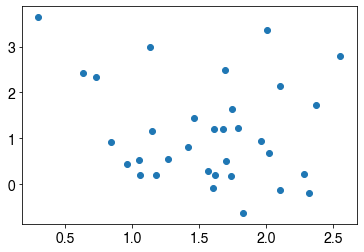

In [253]:
plt.scatter(yt,kt)

yield trend vs. kdd trend: coef = -0.01, p = 0.00
starting yields vs. kdd trends: coef = 0.55, p = 0.00


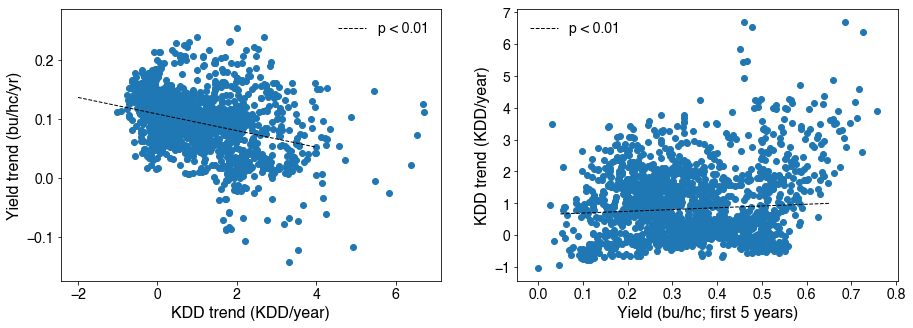

In [254]:
# countyList = usCounties[(usCounties['STATE']=='IA')]
countyList = usCounties

yieldVarDetrend = 'maizeYieldDetrendDeepak'
yieldTrendVar = 'maizeYieldTrendDeepak'
yieldVar = 'maizeYieldDeepak'

gddAnoms = np.array(list(countyList['gddDetrend']))
kddAnoms = np.array(list(countyList['kddDetrend']))
yieldAnoms = np.array(list(countyList[yieldVarDetrend]))

nn = np.where((~np.isnan(gddAnoms)) & (~np.isnan(kddAnoms)) & (~np.isnan(yieldAnoms)))[0]
gddAnoms = gddAnoms[nn]
kddAnoms = kddAnoms[nn]
yieldAnoms = yieldAnoms[nn]

gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList[yieldVarDetrend]))])))

nn = np.where((~np.isnan(gddAnomAgg)) & (~np.isnan(kddAnomAgg)) & (~np.isnan(yieldAnomAgg)))[0]
gddAnomAgg = gddAnomAgg[nn]
kddAnomAgg = kddAnomAgg[nn]
yieldAnomAgg = yieldAnomAgg[nn]

kddTrendAgg = np.array([x for x in countyList['kddTrend']])
yieldTrendAgg = np.array([x for x in countyList[yieldTrendVar]])

kddTrendAggNorm = (kddTrendAgg-np.nanmin(kddTrendAgg))/np.nanmax(kddTrendAgg)
yieldTrendAggNorm = (yieldTrendAgg-np.nanmin(yieldTrendAgg))/np.nanmax(yieldTrendAgg)

gddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gdd']))])))
kddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kdd']))])))
yieldValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList[yieldVar]))])))

nn = np.where((~np.isnan(gddValsAgg)) & (~np.isnan(kddValsAgg)) & (~np.isnan(yieldValsAgg)))[0]
gddValsAgg = gddValsAgg[nn]
kddValsAgg = kddValsAgg[nn]
yieldValsAgg = yieldValsAgg[nn]

startingYields = []
for startingYield in np.array(list(countyList[yieldVar])):
    ind1 = np.where(~np.isnan(startingYield))[0][0]
    ind2 = ind1+5
    if ind2 > len(startingYield): ind2 = len(startingYield)
    startingYields.append(np.nanmean(startingYield[ind1:ind2]))
startingYields = np.array(startingYields)

nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(yieldTrendAgg)) & (~np.isnan(startingYields)))[0]
kddTrendAgg = kddTrendAgg[nn]
yieldTrendAgg = yieldTrendAgg[nn]
startingYields = startingYields[nn]
    
startingYieldsNorm = (startingYields-np.nanmin(startingYields)) / np.nanmax(startingYields)

f, (ax1, ax3) = plt.subplots(figsize=(15, 5), nrows=1, ncols=2, squeeze=True)

X = sm.add_constant(kddTrendAgg)
mdl1 = sm.RLM(yieldTrendAgg, X).fit()

ax1.scatter(kddTrendAgg, yieldTrendAgg)
ax1.plot([-2, 4], mdl1.params[0]+[-2*mdl1.params[1], 4*mdl1.params[1]], '--k', lw=1, label = 'p < 0.01')
ax1.set_xlabel('KDD trend (KDD/year)')
ax1.set_ylabel('Yield trend (bu/hc/yr)')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)


# ax2.scatter(kddValsAgg, yieldValsAgg)
# ax2.set_xlabel('KDD anomaly')
# ax2.set_ylabel('Yield anomaly')

# X = sm.add_constant(startingYieldsNorm)
# mdl2 = sm.RLM(yieldTrendAgg, X).fit()

# ax2.scatter(startingYieldsNorm, yieldTrendAgg, c=kddTrendAggNorm, cmap='Reds')
# ax2.plot([0.05, 0.65], mdl2.params[0]+[0.05*mdl2.params[1], 0.65*mdl2.params[1]], '--k', lw=1, label = 'p = 0.01')
# ax2.set_xlabel('Yield (1981-1985)')
# ax2.set_ylabel('Yield trend')
# l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
# l2.get_frame().set_linewidth(0)


X = sm.add_constant(startingYieldsNorm)
mdl3 = sm.RLM(kddTrendAgg, X).fit()

ax3.scatter(startingYieldsNorm, kddTrendAgg)
ax3.plot([0.05, 0.65], mdl3.params[0]+[0.05*mdl3.params[1], 0.65*mdl3.params[1]], '--k', lw=1, label = 'p < 0.01')
ax3.set_xlabel('Yield (bu/hc; first 5 years)')
ax3.set_ylabel('KDD trend (KDD/year)')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
l3.get_frame().set_linewidth(0)


print('yield trend vs. kdd trend: coef = %.2f, p = %.2f'%(mdl1.params[1], mdl1.pvalues[1]))
# print('starting yields vs. yield trends: coef = %.4f, p = %.2f'%(mdl2.params[1], mdl2.pvalues[1]))
print('starting yields vs. kdd trends: coef = %.2f, p = %.2f'%(mdl3.params[1], mdl3.pvalues[1]))


In [255]:
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrend']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))
    

data = {'GDD':gddAnomAgg, \
        'KDD':kddAnomAgg, \
        'Pr':prAnomAgg, 'Pr2':prAnomAgg**2, \
        'County':countyFE, \
        'Yield':yieldAnomAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
mdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     6600.
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:31:25   Log-Likelihood:            -2.5387e+05
No. Observations:               59098   AIC:                         5.078e+05
Df Residuals:                   59094   BIC:                         5.078e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0175      0.073     -0.239      0.811      -0.161       0.126
GDD            0.0332      0.001     24.159      0.000       0.031       0.036
KDD           -0.1974      0.002    -85.199      0.000      -0.202      -0.193
Pr             0.2841      0.028     10.056      0.000       0.229       0.339
==============================================================================
Omnibus:                     5350.465   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10686.339
Skew:                          -0.605   Prob(JB):                         0.00
Kurtosis:                       4.696   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [256]:
gddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrendDeepak']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))

nn = np.where((~np.isnan(gddAnomAggDeepak)) & (~np.isnan(kddAnomAggDeepak)) & (~np.isnan(prAnomAggDeepak)) & (~np.isnan(yieldAnomAggDeepak)))[0]

data = {'GDD':gddAnomAggDeepak[nn], \
        'KDD':kddAnomAggDeepak[nn], \
        'Pr':prAnomAggDeepak[nn], 'Pr2':prAnomAggDeepak[nn]**2, \
        'County':countyFE[nn], \
        'Yield':yieldAnomAggDeepak[nn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
mdlDeepak = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
mdlDeepak.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     9070.
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:31:26   Log-Likelihood:                -82875.
No. Observations:               60575   AIC:                         1.658e+05
Df Residuals:                   60571   BIC:                         1.658e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0289      0.004      7.482      0.000       0.021       0.037
GDD            0.0016   7.36e-05     21.125      0.000       0.001       0.002
KDD           -0.0109      0.000    -91.150      0.000      -0.011      -0.011
Pr             0.0271      0.001     18.067      0.000       0.024       0.030
==============================================================================
Omnibus:                     5598.728   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10497.047
Skew:                          -0.635   Prob(JB):                         0.00
Kurtosis:                       4.595   Cond. No.                         111.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [257]:
stateMdls = {}

# build state models
for state in usStateAbbrev.values():
    
    gddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['gddDetrend']))])))
    kddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['kddDetrend']))])))
    prAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['seasonalPrecipDetrend']))])))
    yieldAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['maizeYieldDetrend']))])))
    
    nn = np.where((~np.isnan(gddAgg)) & (~np.isnan(kddAgg)) & (~np.isnan(prAgg)) & (~np.isnan(yieldAgg)))[0]
    
    if len(nn) > 100:
#         print('building model for %s, n = %d'%(state, len(nn)))
    
        data = {'GDD':gddAgg[nn], \
            'KDD':kddAgg[nn], \
            'Pr':prAgg[nn], 'Pr2':prAgg[nn]**2, \
            'Yield':yieldAgg[nn]}

        df = pd.DataFrame(data, \
                          columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                   'Yield'])
        stateMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
        stateMdls[state] = stateMdl

In [258]:
periodLen = range(5, 10)

countyFips = np.array(list(countyList['FIPS']))
states = np.array(list(countyList['STATE']))
startingYields = np.array(list(countyList['maizeYield']))
startingYieldsDeepak = np.array(list(countyList['maizeYieldDeepak']))

countyOutcomes = {}
countyOutcomesDeepak = {}
countyOutcomesCounty = {}
countyOutcomesState = {}
countyGddChg = {}
countyKddChg = {}
countyPrChg = {}

for c, fips in enumerate(countyFips):
    if c % 50 == 0:
        print('%.0f %%'%(c/len(countyFips)*100))
    
    curCountyOutcomes = []
    curCountyOutcomesDeepak = []
    curCountyOutcomesCounty = []
    curCountyOutcomesState = []
    curCountyGddChg = []
    curCountyKddChg = []
    curCountyPrChg = []
    
    countyGdd = np.array(list(usCounties['gddDetrend']))[c, :]
    countyKdd = np.array(list(usCounties['kddDetrend']))[c, :]
    countyPr = np.array(list(usCounties['seasonalPrecipDetrend']))[c, :]
    countyYield = np.array(list(usCounties['maizeYieldDetrend']))[c, :]
    
    nn = np.where((~np.isnan(countyGdd)) & (~np.isnan(countyKdd)) & (~np.isnan(countyPr)) & (~np.isnan(countyYield)))[0]
    
    # build county-specific model
    data = {'GDD':countyGdd[nn], \
            'KDD':countyKdd[nn], \
            'Pr':countyPr[nn], 'Pr2':countyPr[nn]**2, \
            'Yield':countyYield[nn]}
                        
    df = pd.DataFrame(data, \
                      columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                               'Yield'])
    countyMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
    
#     countyYieldInd1 = np.where(~np.isnan(startingYields[c, :]))[0][0]
#     countyYieldInd2 = np.where(~np.isnan(startingYields[c, :]))[0][-1]
    
#     countyYieldIndDeepak1 = np.where(~np.isnan(startingYieldsDeepak[c, :]))[0][0]
#     countyYieldIndDeepak2 = np.where(~np.isnan(startingYieldsDeepak[c, :]))[0][-1]
    
    curCountyGdd = np.array(list(usCounties['gdd']))[c, :]
    curCountyKdd = np.array(list(usCounties['kdd']))[c, :]
    curCountyPr = np.array(list(usCounties['seasonalPrecip']))[c, :]
    
    for p in periodLen:
            
#         curCountyStartingYields = np.nanmean(startingYields[c, countyYieldInd1:countyYieldInd1+p])
#         curCountyStartingYieldsDeepak = np.nanmean(startingYieldsDeepak[c, countyYieldIndDeepak1:countyYieldIndDeepak1+p])
        curCountyGddStart = curCountyGdd[0:p+1]
        curCountyKddStart = curCountyKdd[0:p+1]
        curCountyPrStart = curCountyPr[0:p+1]

        curCountyGddEnd = curCountyGdd[len(curCountyGdd)-p:]
        curCountyKddEnd = curCountyKdd[len(curCountyKdd)-p:]
        curCountyPrEnd = curCountyPr[len(curCountyPr)-p:]
        
        XStart = {'GDD':curCountyGddStart, 'KDD':curCountyKddStart, 'Pr':curCountyPrStart, 'Pr2':curCountyPrStart**2, 'County':[c]*len(curCountyGddStart)}
        XEnd = {'GDD':curCountyGddEnd, 'KDD':curCountyKddEnd, 'Pr':curCountyPrEnd, 'Pr2':curCountyPrEnd**2, 'County':[c]*len(curCountyGddEnd)}

        predDeepak1 = mdlDeepak.predict(XStart).mean()
        predDeepak2 = mdlDeepak.predict(XEnd).mean()
        
        if predDeepak1 != 0:
            predChgDeepak = (predDeepak2-predDeepak1)/predDeepak1*100
        else:
            predChgDeepak = np.nan
        
        pred1 = mdl.predict(XStart).mean()
        pred2 = mdl.predict(XEnd).mean()
        
        if pred1 != 0:
            predChg = (pred2-pred1)/pred1*100
        else:
            predChg = np.nan
        
        predCounty1 = countyMdl.predict(XStart).mean()
        predCounty2 = countyMdl.predict(XEnd).mean()
        
        if predCounty1 != 0:
            predChgCounty = (predCounty2-predCounty1)/predCounty1*100
        else:
            predChgCounty = np.nan
        
        if states[c] in stateMdls.keys():
            predState1 = stateMdls[states[c]].predict(XStart).mean()
            predState2 = stateMdls[states[c]].predict(XEnd).mean()

            if predState1 != 0:
                predChgState = (predState2-predState1)/predState1*100
            else:
                predChgState = np.nan
        else:
            predChgState = np.nan
        
        if predChg < -100 or predChg > 500: predChg = np.nan
        if predChgCounty < -100 or predChgCounty > 500: predChgCounty = np.nan
        if predChgState < -100 or predChgState > 500: predChgState = np.nan
        if predChgDeepak < -100 or predChgDeepak > 500: predChgDeepak = np.nan

        curCountyOutcomes.append(predChg)
        curCountyOutcomesDeepak.append(predChgDeepak)
        curCountyOutcomesCounty.append(predChgCounty)
        curCountyOutcomesState.append(predChgState)
        
        curCountyGddChg.append(np.nanmean(curCountyGddEnd) - np.nanmean(curCountyGddStart))
        curCountyKddChg.append(np.nanmean(curCountyKddEnd) - np.nanmean(curCountyKddStart))
        curCountyPrChg.append(np.nanmean(curCountyPrEnd) - np.nanmean(curCountyPrStart))
    
    countyOutcomes[c] = np.nanmean(curCountyOutcomes)
    countyOutcomesCounty[c] = np.nanmean(curCountyOutcomesCounty)
    countyOutcomesState[c] = np.nanmean(curCountyOutcomesState)
    countyOutcomesDeepak[c] = np.nanmean(curCountyOutcomesDeepak)
    countyGddChg[c] = np.nanmean(curCountyGddChg)
    countyKddChg[c] = np.nanmean(curCountyKddChg)
    countyPrChg[c] = np.nanmean(curCountyPrChg)

0 %
3 %
5 %
8 %
11 %
14 %
16 %
19 %
22 %
24 %
27 %
30 %
33 %
35 %
38 %
41 %
44 %
46 %
49 %
52 %
54 %
57 %
60 %
63 %
65 %
68 %
71 %
73 %
76 %
79 %
82 %
84 %
87 %
90 %
93 %
95 %
98 %


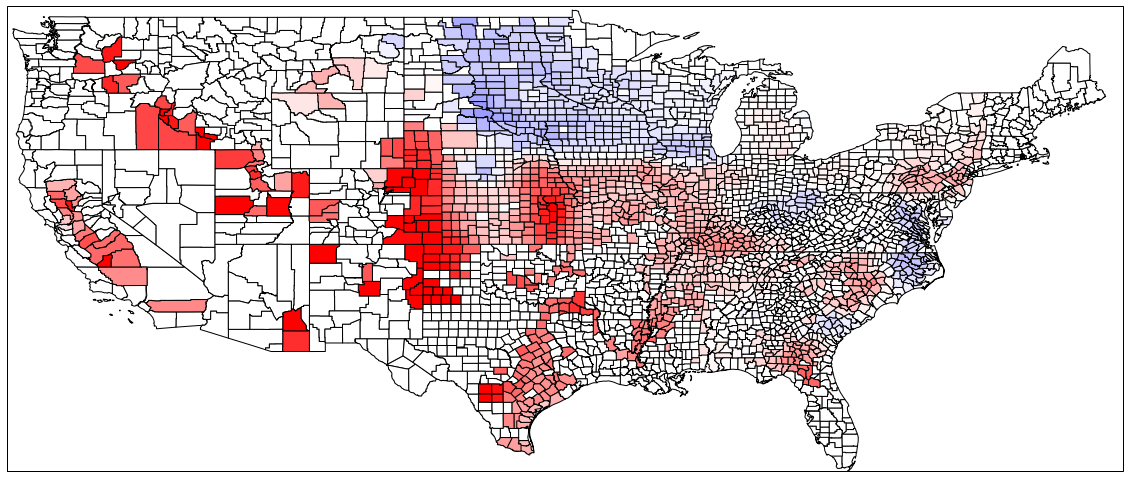

In [259]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-100, vmax=100)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyKddChg.keys():
        curKddChg = countyKddChg[ind[0]]
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curKddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

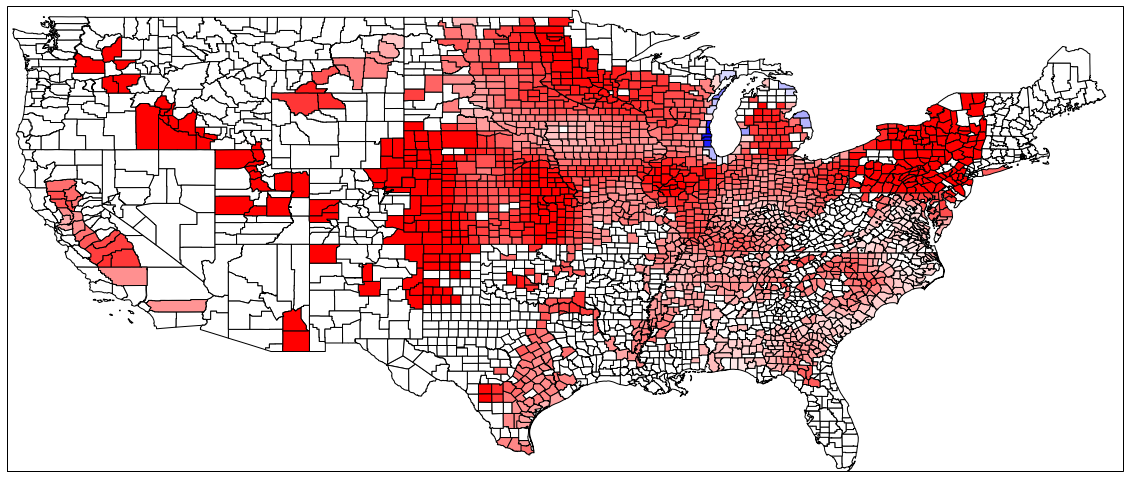

In [260]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-100, vmax=100)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyGddChg.keys():
        curGddChg = countyGddChg[ind[0]]
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curGddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

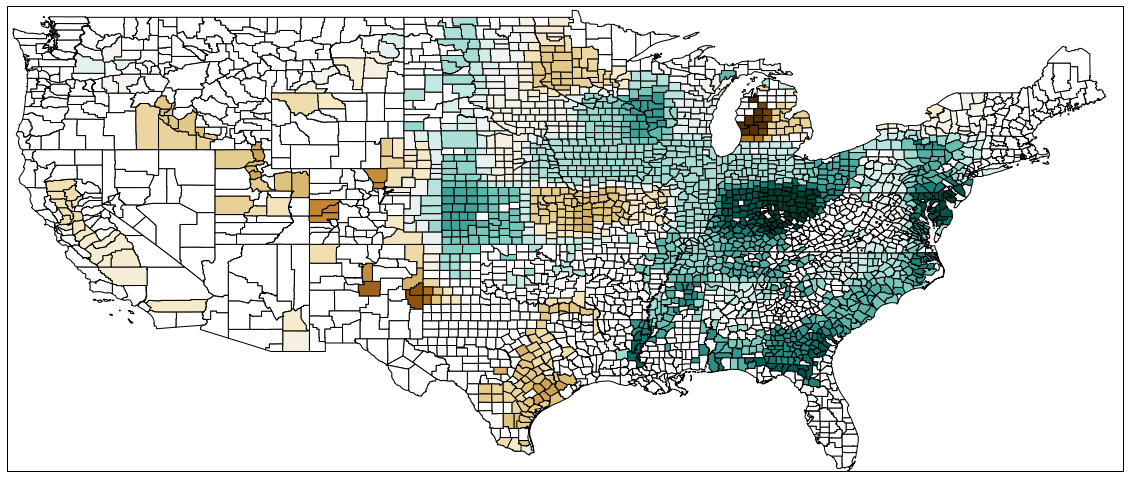

In [261]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-3, vmax=3)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyPrChg.keys():
        curPrChg = countyPrChg[ind[0]]
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curPrChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

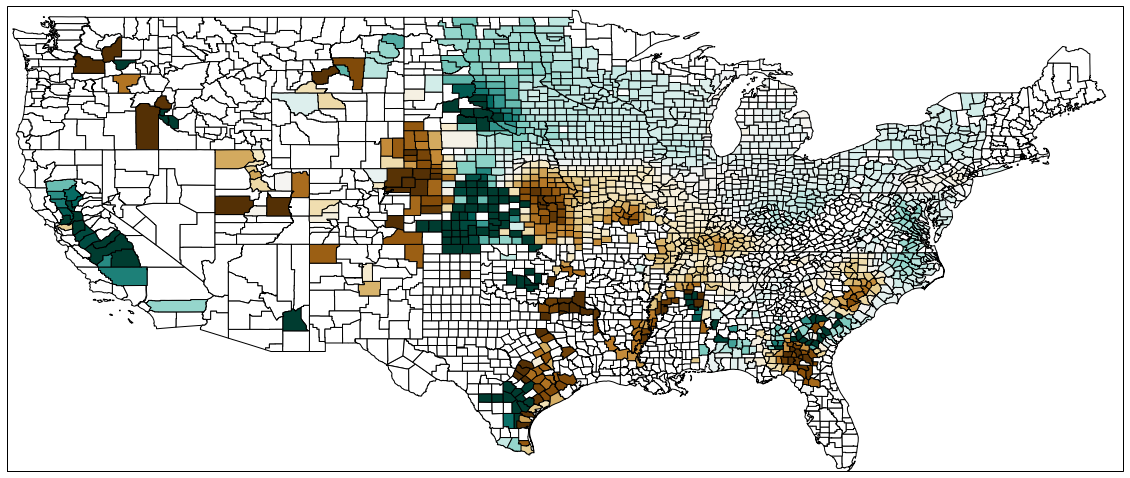

In [262]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-75, vmax=75)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomes.keys():
        curYieldChg = countyOutcomes[ind[0]]
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

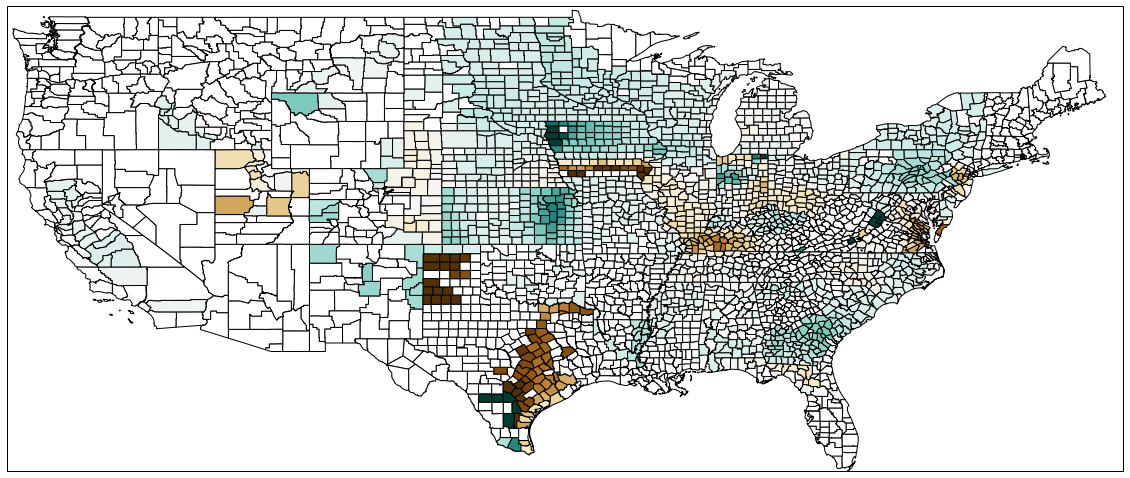

In [263]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-75, vmax=75)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesState.keys():
        curYieldChg = countyOutcomesState[ind[0]]
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

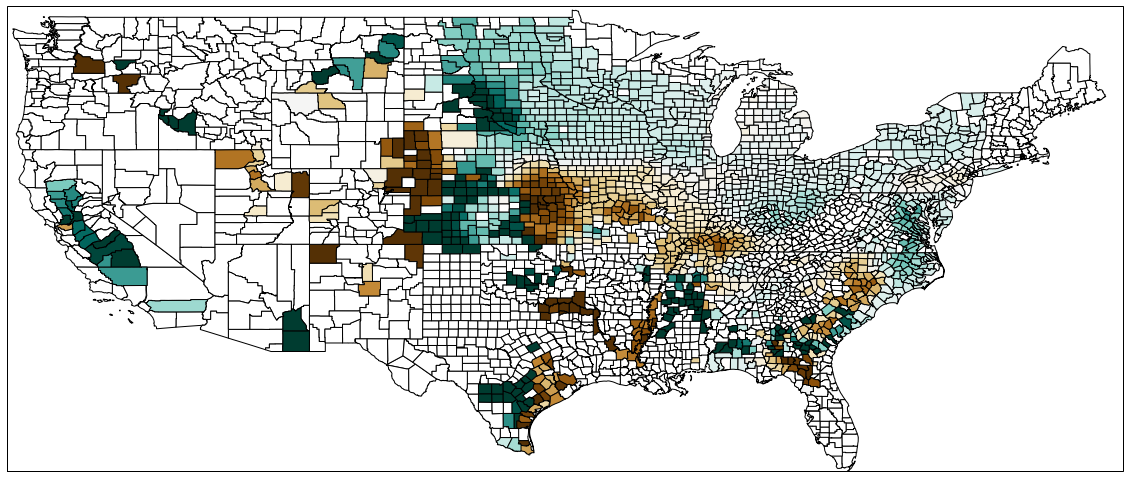

In [264]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-75, vmax=75)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesDeepak.keys():
        curYieldChg = countyOutcomesDeepak[ind[0]]
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

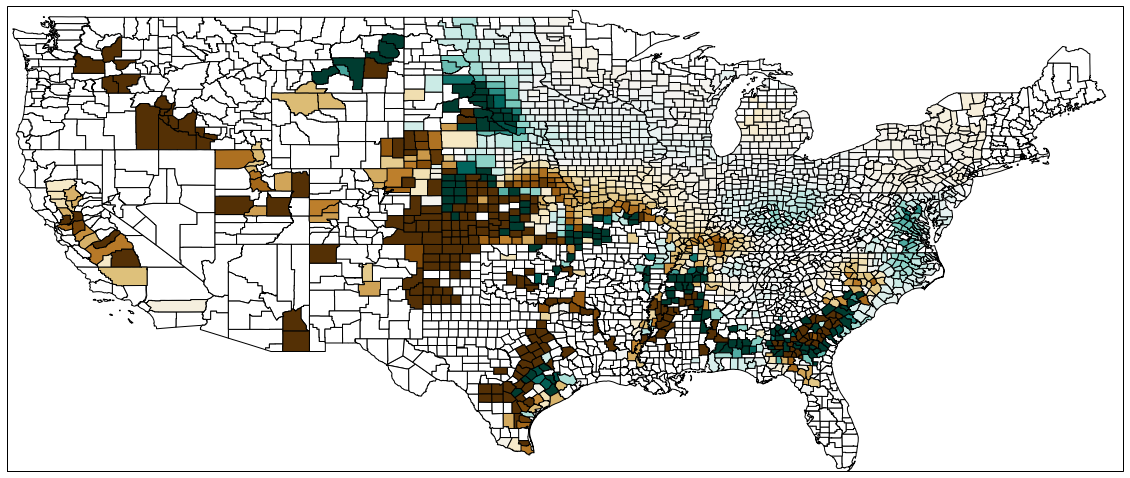

In [265]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesDeepak.keys():
        curYieldChg = countyOutcomesDeepak[ind[0]]-countyOutcomes[ind[0]]
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

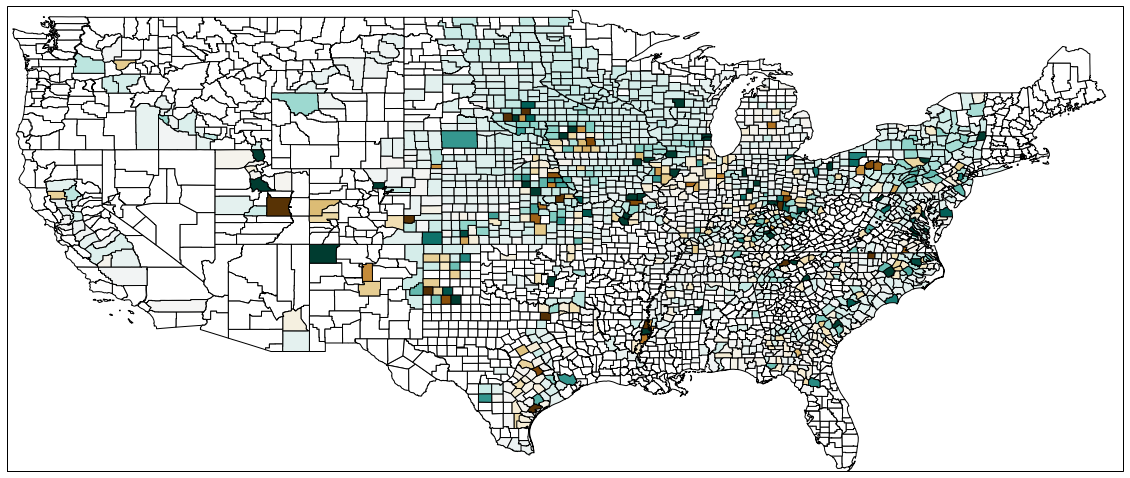

In [266]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-75, vmax=75)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesCounty.keys():
        curYieldChg = countyOutcomesCounty[ind[0]]
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
plt.show()

In [267]:
startPeriod = range(3, 15)
endPeriod = range(3, 15)

yieldRangeThreshLen = 20
lowYieldThresh = range(10,10+yieldRangeThreshLen)
highYieldThresh = range(70,70+yieldRangeThreshLen)

pl = []
ph = []
pa = []

plDeepak = []
phDeepak = []
paDeepak = []

N = yieldRangeThreshLen*len(startPeriod)*len(endPeriod)
n = 0

for r in range(yieldRangeThreshLen):

    for sp in startPeriod:
        
        startingYields = []
        countyInds = []
        for startingYield in np.array(list(countyList['maizeYield'])):
            indStart = np.where(~np.isnan(startingYield))[0][0]
            indEnd = np.where(~np.isnan(startingYield))[0][-1]

            countyInds.append((indStart, indEnd))

            ind2 = indStart+sp
            if ind2 > len(startingYield): 
                ind2 = len(startingYield)
            startingYields.append(np.nanmean(startingYield[indStart:ind2]))

        indLow = np.where((startingYields < np.nanpercentile(startingYields, lowYieldThresh[r])))[0]
        indHigh = np.where((startingYields >= np.nanpercentile(startingYields, highYieldThresh[r])))[0]

        for ep in endPeriod:
            
            if n % 100 == 0:
                print('%.0f %%'%(n/N*100))
            
            n += 1
            
            gddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp+1] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
            kddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp+1] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
            prAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp+1] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
            countyFELowStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indLow])))

            gddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
            kddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
            prAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
            countyFELowEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indLow])))

            gddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp+1] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
            kddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp+1] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
            prAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp+1] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
            countyFEAllStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))

            gddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
            kddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
            prAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
            countyFEAllEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))

            gddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp+1] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
            kddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp+1] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
            prAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp+1] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
            countyFEHighStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indHigh])))

            gddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
            kddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
            prAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
            countyFEHighEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indHigh])))

            XLowStart = {'GDD':gddAggLowStart, 'KDD':kddAggLowStart, 'Pr':prAggLowStart, 'Pr2':prAggLowStart**2, 'County':countyFELowStart}
            XLowEnd = {'GDD':gddAggLowEnd, 'KDD':kddAggLowEnd, 'Pr':prAggLowEnd, 'Pr2':prAggLowEnd**2, 'County':countyFELowEnd}
            XHighStart = {'GDD':gddAggHighStart, 'KDD':kddAggHighStart, 'Pr':prAggHighStart, 'Pr2':prAggHighStart**2, 'County':countyFEHighStart}
            XHighEnd = {'GDD':gddAggHighEnd, 'KDD':kddAggHighEnd, 'Pr':prAggHighEnd, 'Pr2':prAggHighEnd**2, 'County':countyFEHighEnd}
            XAllStart = {'GDD':gddAggAllStart, 'KDD':kddAggAllStart, 'Pr':prAggAllStart, 'Pr2':prAggAllStart**2, 'County':countyFEAllStart}
            XAllEnd = {'GDD':gddAggAllEnd, 'KDD':kddAggAllEnd, 'Pr':prAggAllEnd, 'Pr2':prAggAllEnd**2, 'County':countyFEAllEnd}

            predLow1 = mdl.predict(XLowStart).mean()
            predLow2 = mdl.predict(XLowEnd).mean()
            if predLow1 > 0 and predLow2 > 0:
                predLow = (predLow2-predLow1)/predLow1*100
                if predLow < -100 or predLow > 500:
                    predLow = np.nan
            else:
                predLow = np.nan

            predHigh1 = mdl.predict(XHighStart).mean()
            predHigh2 = mdl.predict(XHighEnd).mean()
            if predHigh1 > 0 and predHigh2 > 0:
                predHigh = (predHigh2-predHigh1)/predHigh1*100
                if predHigh < -100 or predHigh > 500:
                    predHigh = np.nan
            else:
                predHigh = np.nan

            predAll1 = mdl.predict(XAllStart).mean()
            predAll2 = mdl.predict(XAllEnd).mean()
            if predAll1 > 0 and predAll2 > 0:
                predAll = (predAll2-predAll1)/predAll1*100
                if predAll < -100 or predAll > 500:
                    predAll = np.nan
            else:
                predAll = np.nan

            pl.append(predLow)
            ph.append(predHigh)
            pa.append(predAll)
            

pl = np.array(pl)
ph = np.array(ph)
pa = np.array(pa)

0 %
3 %
7 %
10 %
14 %
17 %
21 %
24 %
28 %
31 %
35 %
38 %
42 %
45 %
49 %
52 %
56 %
59 %
62 %
66 %
69 %
73 %
76 %
80 %
83 %
87 %
90 %
94 %
97 %


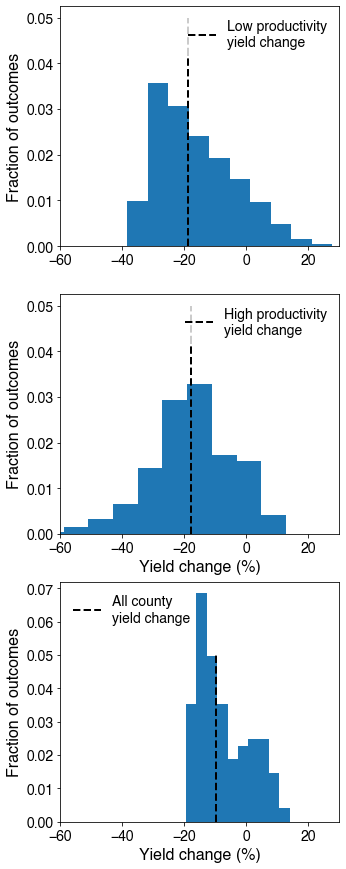

In [268]:
f, (ax1, ax2, ax3) = plt.subplots(figsize=(5, 15), nrows=3, ncols=1, squeeze=True)
ax1.hist(pl, density=True)
ax1.set_xlim([-60, 30])
# ax1.set_ylim([0, .06])
ax1.set_ylabel('Fraction of outcomes')
ax1.plot([np.nanmedian(pl), np.nanmedian(pl)], [0, 0.05], '--k', lw=2, label='Low productivity\nyield change')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

ax2.hist(ph, density=True)
ax2.set_xlim([-60, 30])
# ax2.set_ylim([0, .06])
ax2.set_ylabel('Fraction of outcomes')
ax2.set_xlabel('Yield change (%)')
ax2.plot([np.nanmedian(ph), np.nanmedian(ph)], [0, 0.05], '--k', lw=2, label='High productivity\nyield change')
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
l2.get_frame().set_linewidth(0)

ax3.hist(pa, density=True)
ax3.set_xlim([-60, 30])
# ax3.set_ylim([0, .06])
ax3.set_ylabel('Fraction of outcomes')
ax3.set_xlabel('Yield change (%)')
ax3.plot([np.nanmedian(pa), np.nanmedian(pa)], [0, 0.05], '--k', lw=2, label='All county\nyield change')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
l3.get_frame().set_linewidth(0)

In [269]:
ks_pl_pa = scipy.stats.ks_2samp(pl, pa)
ks_ph_pa = scipy.stats.ks_2samp(ph, pa)

print('KS-test: low productivity vs all counties: %.2f'%ks_pl_pa.pvalue)
print('KS-test: high productivity vs all counties: %.2f'%ks_ph_pa.pvalue)

KS-test: low productivity vs all counties: 0.00
KS-test: high productivity vs all counties: 0.00


In [270]:
# calculate trends in crop yields

for xlat in range(maize.shape[0]):
    for ylon in range(maize.shape[1]):
        nn = np.where(~np.isnan(maize[xlat, ylon, :]))[0]
        if nn.shape[0] > 10:#== maize.shape[2]:
            X = sm.add_constant(range(nn.size))
            mdl = sm.OLS(maize[xlat, ylon, nn], X).fit()
            maizeTrends[xlat, ylon] = mdl.params[1]
        
        nn = np.where(~np.isnan(soybean[xlat, ylon, :]))[0]
        if nn.shape[0] == soybean.shape[2]:
            X = sm.add_constant(range(soybean.shape[2]))
            mdl = sm.OLS(soybean[xlat, ylon, :], X).fit()
            soybeanTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(rice[xlat, ylon, :]))[0]
        if nn.shape[0] == rice.shape[2]:
            X = sm.add_constant(range(rice.shape[2]))
            mdl = sm.OLS(rice[xlat, ylon, :], X).fit()
            riceTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(wheat[xlat, ylon, :]))[0]
        if nn.shape[0] == wheat.shape[2]:
            X = sm.add_constant(range(wheat.shape[2]))
            mdl = sm.OLS(wheat[xlat, ylon, :], X).fit()
            wheatTrends[xlat, ylon] = mdl.params[1]

NameError: name 'maize' is not defined

In [ ]:
cRange=[0, 1]
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.add_feature(cartopy.feature.STATES, edgecolor='black')
c = plt.contourf(lon, lat, np.clip(np.nanmean(seasonalPrecip, axis=2), cRange[0], cRange[1]), cmap='Blues', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .1))
cbar.set_label('%s growing season precip'%crop)
ax.coastlines()